In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn")
colors = sns.color_palette("muted", 10)
sns.set(font='NanumBarunGothic', font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df_train.head()

,sample_id,video_path,label
0,TRAIN_0000,./train/TRAIN_0000.mp4,7
1,TRAIN_0001,./train/TRAIN_0001.mp4,7
2,TRAIN_0002,./train/TRAIN_0002.mp4,0
3,TRAIN_0003,./train/TRAIN_0003.mp4,0
4,TRAIN_0004,./train/TRAIN_0004.mp4,1


In [3]:
len(df_train)

2698

<AxesSubplot:>

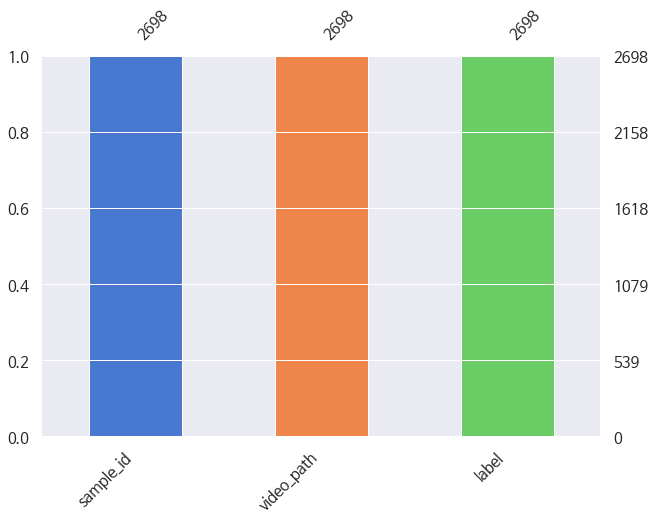

In [4]:
# 결측치 확인
msno.bar(df_train, figsize=(10,7), fontsize=15, color=colors)

## 각 라벨 당 데이터 어케 생겨먹었나
- crash 기준: 0 / 나머지
- ego-involve : 1~6 / 7 ~ 12
- weather: 1,2,7,8/ 3,4,9,10/ 5,6,11,12

In [5]:
print("라벨링: ", df_train["label"].unique())
df_train["label"].value_counts(dropna=False).sort_index()
#ego-Involve, weather, timing의 정보는 '차량 충돌 사고'가 일어난 경우에만 분석합니다 -> 이게 핵심일듯?

라벨링:  [ 7  0  1  3  4  2 11  9  8 10  5  6 12]


0     1783
1      318
2       51
3       78
4       13
5       28
6        3
7      317
8       30
9       34
10       4
11      33
12       6
Name: label, dtype: int64

In [6]:
#라벨 옆에 추가로 각 라벨 당 정보를 적어주자
crush=[]
ego=[]
weather=[]
timing=[]

df_train["crush"]=-1
df_train["ego"]=-1
df_train["weather"]=-1
df_train["timing"]=-1
#crush
for label in df_train["label"]:
    if label==0: #crush no
        crush.append(0)
    else: #crush yes
        crush.append(1)
df_train["crush"]=crush

#ego
for label in df_train["label"]:
    if label==0:
        ego.append(-1)
    elif label<7: #ego yes
        ego.append(1)
    else: #ego no
        ego.append(0)
    
#weather
for label in df_train["label"]:
    #print("st: ", label)
    if label==0:
        weather.append(-1)
    elif label in [1,2,7,8]:
        weather.append(0) #normal
        #print(label)
    elif label in [3,4,9,10]:
        weather.append(1) # snowy
    elif label in [5,6,11,12]:
        weather.append(2) # rainy
    else:
        print("머야 얘는", label)
#timing
for label in df_train["label"]:
    if label==0:
        timing.append(-1)
    elif label%2==1:
        timing.append(0) #day
    else:
        timing.append(1) #night
#print(len(timing))
df_train["crush"]=crush
df_train["ego"]=ego
df_train["weather"]=weather
df_train["timing"]=timing

In [7]:
df_train["crush"].value_counts(dropna=False).sort_index()
#crush는 no가 약 2배정도 

0    1783
1     915
Name: crush, dtype: int64

In [8]:
df_train["ego"].value_counts(dropna=False).sort_index()
#ego는 거의 비슷

-1    1783
 0     424
 1     491
Name: ego, dtype: int64

In [9]:
df_train["weather"].value_counts(dropna=False).sort_index()

#weather는 눈 비가 많이 부족하고 날이 좋은날이 많다

-1    1783
 0     716
 1     129
 2      70
Name: weather, dtype: int64

In [10]:
df_train["timing"].value_counts(dropna=False).sort_index()

#시간은 낮 시간이 훨 많음

-1    1783
 0     808
 1     107
Name: timing, dtype: int64

In [ ]:
df_train.to_csv('train_detail_classified.csv')

## crush와 ego의 라벨을 합쳐주자(0 : 충돌 안함 / 1 : 나랑 충돌 / 2 : 나랑 충돌 안함)

In [ ]:
df_train=df_train.reset_index(drop=True)
df_train

In [ ]:
df_train['crush+ego']=-1 
crush0_idx=df_train.where(df_train['crush']==0).dropna().index
ego1_idx=df_train.where(df_train['ego']==1).dropna().index
ego0_idx=df_train.where(df_train['ego']==0).dropna().index

In [ ]:
for i,row in df_train.iterrows():
    if row['crush']==0:
        df_train['crush+ego'][i]=0
    elif row['ego']==1:
        df_train['crush+ego'][i]=1
    elif row['ego']==0:
        df_train['crush+ego'][i]=2

In [ ]:
df_train.to_csv('train_detail_classified.csv')

In [ ]:
df_train.loc[crush0_idx]['crush+ego']

In [ ]:
df_train.loc[ego1_idx]

## 동영상 길이, 사이즈 확인

In [ ]:
#동영상 길이 확인
import torchvision

stream = "video"
df_crush=df_train.loc[df_train["crush"]==1]

for path in df_train["video_path"]:
    video=torchvision.io.VideoReader(path, stream)
    #print(video.get_metadata())
    info=video.get_metadata()
    if info['video']['duration']!=[5.0]:
        print('다름')
    if info['video']['fps']!=[10.0]:
        print('다름')

#모두 5초 , fps 10(초당 프레임 10)

In [ ]:
import torch
import itertools

def example_read_video(video_object, start=0, end=None, read_video=True, read_audio=True):
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end time should be larger than start time, got "
            f"start time={start} and end time={end}"
        )

    video_frames = torch.empty(0)
    video_pts = []
    if read_video:
        video_object.set_current_stream("video")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            video_frames = torch.stack(frames, 0)

    audio_frames = torch.empty(0)
    audio_pts = []
    if read_audio:
        video_object.set_current_stream("audio")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            audio_pts.append(frame['pts'])
        if len(frames) > 0:
            audio_frames = torch.cat(frames, 0)

    return video_frames, audio_frames, (video_pts, audio_pts), video_object.get_metadata()


# Total number of frames should be 327 for video and 523264 datapoints for audio
vf, af, info, meta = example_read_video(video)
print(vf.size(), af.size())

In [ ]:
#비디오 사이즈 확인

stream = "video"

for path in df_train["video_path"]:
    video=torchvision.io.VideoReader(path, stream)
    vf, _, info, meta= example_read_video(video)
    if(list(vf.shape)!=[50, 3, 720, 1280]):
        print("다름")

#[50, 3, 720, 1280] 

## 시각화

In [11]:
import pandas as pd 
import numpy as np
import cv2 

from ipywidgets import interact
from matplotlib import pyplot as plt

train = pd.read_csv("train_detail_classified.csv")
# 0: None, 1: Normal, 2: Snowy, 3: Rainy
weather=train['weather']

def get_frames(path):
    cap = cv2.VideoCapture(path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    imgs = []        
    for fidx in range(frames):
        _, img = cap.read()            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    
    return np.array(imgs)

def visualize(type):
    if type=='normal':
        path=train.loc[train["weather"]==0, "video_path"].values
    elif type=='snow':
        path=train.loc[train["weather"]==1, "video_path"].values
    elif type=='rain':
        path=train.loc[train["weather"]==2, "video_path"].values
    else:
        ValueError("type 재입력")
        
    @interact(type=type, frame=(0, 50-1), path=path)
    def show_frame(frame=0, path=None):
        frames = np.zeros((1, 20, 20, 3))
        if path:
            frames = get_frames(path)
        plt.imshow(frames[frame,:,:,:])

In [12]:
#원터치 화면체크

def get_sumnail(path, frame=0):
    cap = cv2.VideoCapture(path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #imgs = []        
    for fidx in range(frames):
        if fidx!=frame:
            continue
        _, img = cap.read()            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if fidx==frame:
            break
        #imgs.append(img)
    return img
def visualize_block(pathes, start=0, block_size=5):
    fig=plt.figure(figsize=(50, 50))
    for i in range(1,block_size**2+1):
        ax=plt.subplot(block_size,block_size,i)
        ax.set_title(f'path {pathes[i-1][-9:-4]}')
        ax.imshow(get_sumnail(pathes[i-1]))
        plt.axis("off")
        start+=1
    #plt.show()
    return fig,start



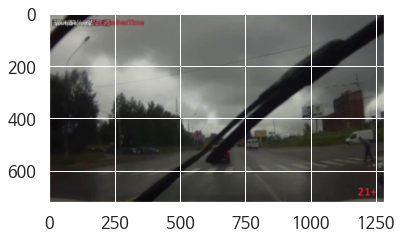

In [16]:
plt.imshow(get_sumnail(pathes_rain[0]))

In [13]:
pathes_rain=train.loc[train["weather"]==2, "video_path"].values
#idx=0
#while(True):
#    if idx>(int(len(pathes_rain)/25)*len(pathes_rain)+(len(pathes_rain)%25)-1):
#        fig,idx=visualize_block(pathes_rain[idx:], idx, 5)
#    else:
#        fig,idx=visualize_block(pathes_rain[idx:idx+25], idx, 5)
#    #print(idx)
